# Vehicle Detection and Tracking

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import glob
import pickle
from collections import deque

HEAT_MAP_HISTORY = deque(maxlen=10)
HEAT_MAP_HISTORY.clear()

In [2]:
# import urllib.request
# import shutil
# import zipfile

# url = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip'
# filename = 'non-vehicles.zip'
# with urllib.request.urlopen(url) as response, open(filename, 'wb') as out_file:
#     shutil.copyfileobj(response, out_file)
#     print('File Downloaded')

In [3]:
# zip_ref = zipfile.ZipFile('./non-vehicles.zip', 'r')
# zip_ref.extractall('./data/kitti/')
# zip_ref.close()

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
def bin_spatial(img, size=(16, 16)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [6]:
def color_hist(img, nbins=16, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
def extract_features(imgs, cspace='RGB', orientations=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32,32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orientations, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orientations, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features=bin_spatial(feature_image, spatial_size)
        # Apply color_hist() to get color histogram features
        hist_features=color_hist(feature_image, hist_bins)
        
#         print(spatial_features.shape, hist_features.shape, hog_features.shape)
        all_features = np.hstack(( spatial_features, hist_features, hog_features))
        # Append the new feature vector to the features list
        features.append(all_features)
    # Return list of feature vectors
    return features

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from time import time

def train_SVM():
    # Divide up into cars and notcars
    print('Traing data (image count) -')
    print('KITTI')
    # KITTI images
    images = glob.glob('./data/kitti/*.png')
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)
    print('Cars images:', len(cars))
    print('Non-Car images:', len(notcars))

    ### GTI Images
    images = glob.glob('./data/GTI/GTI_Far/*.png')
    print('GTI_far',len(images))
    for image in images:
        cars.append(image)
    images = glob.glob('./data/GTI/GTI_Left/*.png')
    print('GTI_Left',len(images))
    for image in images:
        cars.append(image)
    images = glob.glob('./data/GTI/GTI_Right/*.png')
    print('GTI_Right',len(images))
    for image in images:
        cars.append(image)
    images = glob.glob('./data/GTI/GTI_MiddleClose/*.png')
    print('GTI_MiddleClose',len(images))
    for image in images:
        cars.append(image)
    
    images = glob.glob('./data/GTI/Non_vehicle/*.png')
    print('Non_vehicle',len(images))
    for image in images:
        notcars.append(image)
    

    ### TODO: Tweak these parameters and see how the results change.
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12
    pix_per_cell = 16
    cell_per_block = 4
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"

    t = time()
    car_features = extract_features(cars, cspace=colorspace, orientations=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars, cspace=colorspace, orientations=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    print('Car Features shape',car_features[0].shape)
    t2 = time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a non-linear SVC 
    svc = SVC()
    
    # prepare a uniform distribution to sample for the C parameter
#     param_dict = {'C': np.random.uniform(50,100,200)}
#     svc = RandomizedSearchCV(estimator=svc, param_distributions=param_dict, n_iter=10)
    
    
    # Check the training time for the SVC
    t=time()
    svc.fit(X_train, y_train)
    t2 = time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t = time()
    n_predict = 20
    print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
#     print( "Best Parameters for model is:", svc.best_params_)
    
    # Save the model
    with open('svc.pickle','wb') as pickle_file:
        print('Saving SVC in pickle.....')
        pickle.dump({'svc': svc, 'scaler': X_scaler}, pickle_file)
        print('SVC saved.')

In [9]:
# train_SVM()

In [10]:
def get_saved_SVM():
    print('Loading model....')
    with open('svc.pickle','rb') as pickle_file:
        print('SVC loaded')
        obj = pickle.load(pickle_file)
        return obj[ 'svc' ], obj[ 'scaler' ]

In [11]:
SVC, SCALER = get_saved_SVM()

Loading model....
SVC loaded


In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [13]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [14]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

In [15]:
def hot2rgb( heatmap ):
    min_value, max_value = np.amin(heatmap), np.amax(heatmap)
    normalized_hm = ( heatmap - min_value ) / ( max_value - min_value )
    cmap = plt.get_cmap('hot')
    rgba = cmap(normalized_hm) * 255
    
    r,g,b = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2]
    return np.dstack((r,g,b))

In [16]:
from scipy.ndimage.measurements import label

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    box_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    red = np.random.randint(1,200)
    green = np.random.randint(100,250)
    for xb in range(nxsteps):
        ypos = 0 #since scaling factor along y will always be 1
        xpos = xb*cells_per_step
        # Extract HOG for this patch
        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

        hog_features = np.hstack((hog_feat1))

        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell

        # Extract the image patch
        subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

        # Get color features
        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        # Scale features and make a prediction
        test_features = X_scaler.transform(np.hstack(( spatial_features, hist_features, hog_features)).reshape(1, -1))    
        #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
        test_prediction = svc.predict(test_features)

        if test_prediction == 1:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,255),6) 
            box_list.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
            
        cv2.rectangle(draw_img,(np.int(xleft*scale), np.int(ytop*scale)+ystart),(np.int(xleft*scale)+np.int(window*scale),np.int(ytop*scale)+np.int(window*scale)+ystart),(red,green,(red+green)//2),3)
            
    
    return draw_img, box_list

In [17]:
def pipeline(img):
    
    global HEAT_MAP_HISTORY
    
    svc = SVC
    X_scaler = SCALER
    orient = 12
    pix_per_cell = 16
    cell_per_block = 4
    spatial_size = (32,32)
    hist_bins = 32
    
    ystart_list = [400,400, 410, 410, 420, 430]
    ystop_list = [464,480, 506, 538, 580, 610]
    scale_list = [64/64, 80/64, 96/64, 128/64, 160/64, 180/64]

    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_map_with_history = np.zeros_like(img[:,:,0]).astype(np.float)
    for ystart, ystop, scale in zip(ystart_list,ystop_list,scale_list):
        out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heat_map = add_heat(heat_map,box_list)
#         plt.figure(figsize=(15,10))
#         plt.subplot(1,2,1)
#         plt.imshow(out_img)
#         plt.subplot(1,2,2)
#         plt.imshow(heat_map, cmap='hot')

    # Heat map history
    HEAT_MAP_HISTORY.append(apply_threshold(heat_map,1))
    
#     heat_map = np.concatenate(np.array(HEAT_MAP_HISTORY))
    for h_map in HEAT_MAP_HISTORY:
        heat_map_with_history += np.array(h_map)
        
        
    
    # Clip heat_map_with_history    
    heat_map_with_history = np.clip(heat_map_with_history, 0, 255)
    
    #Apply Threshold
    heat_map_with_history = apply_threshold(heat_map_with_history, min(len(HEAT_MAP_HISTORY), 10))
    
    # Find final boxes from heatmap using label function
    labels = label(heat_map_with_history)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heat_map_with_history


In [18]:
def process_clip(image):
    result, heatmap = pipeline( image )
#     plt.figure(figsize=(15,10))
    
#     plt.subplot(1,2,1)
#     plt.imshow( heatmap, cmap='hot' )
    
#     plt.subplot(1,2,2)
#     plt.imshow( result )
    
    heatmap = cv2.resize(heatmap,None,fx=0.25,fy=0.25,interpolation = cv2.INTER_AREA)
    rgb_img = hot2rgb(heatmap)
    result[:int(result.shape[0]*0.25),int(result.shape[1]*0.75):result.shape[1] ] = result[:int(result.shape[0]*0.25),int(result.shape[1]*0.75):result.shape[1] ]*0.3 + 0.7*rgb_img
    return result

C:\Users\arindam.baidya01\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\arindam.baidya01\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


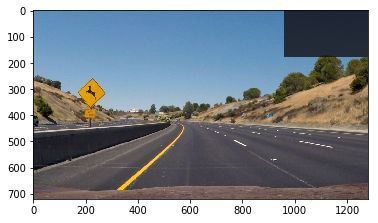

In [19]:
HEAT_MAP_HISTORY.clear()
image = plt.imread('./test_images/test2.jpg')
image = process_clip(image)
plt.figure()
plt.imshow(image)
plt.show()

C:\Users\arindam.baidya01\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\arindam.baidya01\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


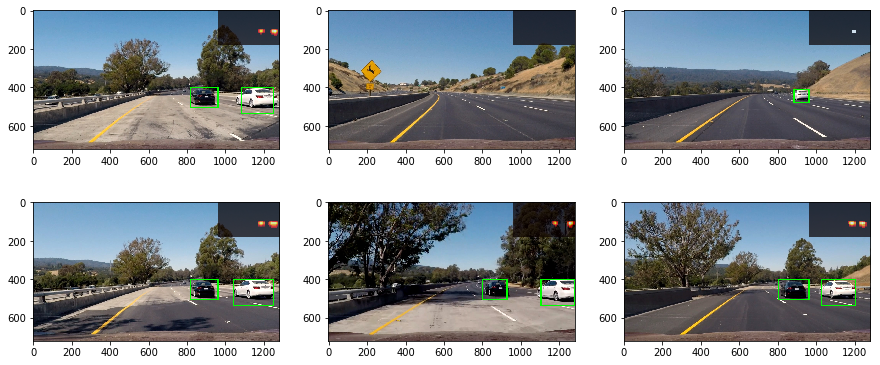

In [20]:
images = glob.glob('./test_images/t*.jpg')
plt.figure(figsize=(15,10))
i=1
for imagepath in images:
    HEAT_MAP_HISTORY.clear()
    image = mpimg.imread(imagepath)
    image = process_clip(image)
    plt.subplot(3,3,i)
    plt.imshow(image)
    i+=1
plt.show()

In [21]:
from moviepy.editor import VideoFileClip

def make_video(destination_path, source_path):
    global HEAT_MAP_HISTORY
    HEAT_MAP_HISTORY.clear()
    ##clip1 = VideoFileClip("project_video.mp4").subclip(39,43)
    clip1 = VideoFileClip(source_path).subclip(22,25)
    lane_clip = clip1.fl_image(process_clip)
    %time lane_clip.write_videofile(destination_path, audio=False)

In [22]:
make_video('output_video/project_video_small.mp4', 'project_video.mp4')

[MoviePy] >>>> Building video output_video/project_video_small.mp4
[MoviePy] Writing video output_video/project_video_small.mp4


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 75/76 [02:17<00:01,  1.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_small.mp4 

Wall time: 2min 19s


In [23]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_video/project_video_small.mp4'))

# Testing

(64, 64, 3)
(3072,) (96,) (192,)
[1.]


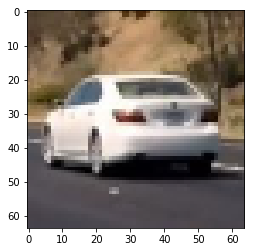

In [24]:
def testing():
    svc = SVC
    X_scaler = SCALER
    image = mpimg.imread('./test_images/MyTest.jpg')
    image = cv2.resize(image,(64,64))
    print(image.shape)
    plt.imshow(image)
    spatial_features = bin_spatial(image, size=(32,32))
    hist_features = color_hist(image, nbins=32)
    hog_features1 = get_hog_features(image[:,:,0], 12, 16, 4, feature_vec=False).ravel()
    hog_features = np.hstack((hog_features1))
    
    print( spatial_features.shape, hist_features.shape, hog_features.shape)
    # Scale features and make a prediction
    test_features = X_scaler.transform(np.hstack(( spatial_features, hist_features, hog_features)).reshape(1, -1))    
    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
    test_prediction = svc.predict(test_features)
    print(test_prediction)

testing()